In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials

In [179]:
# Generate the constants
N = 100
r = 5 #um
SA = 4*pi*r 
V = (4/3)*pi*r^2
mem_thickness = 0.01
n = (mem_thickness * SA) / V

Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
Ax[1,end] = 1.0
Ax[end,1] = 1.0
dx = (r*sqrt(pi))/N
Ax = Ax/(dx^2) # adjust for 1/microns
Ay = copy(Ax)

r0 = zeros(100,100,6)
r0[:,:,1] .= 100 .*(rand.())   # Cdc42-GTPm
r0[:,:,2] .= 22.2*2 .*(rand.())   # Cdc42-GDPm
r0[:,:,3] .= 1              # Cdc42-GDPc
# total Cdc42 = 1uM
r0[:,:,4] .= 0.017             # BemGEFc
r0[:,:,5] .= 0.0431                # BemGEFm
r0[:,:,6] .= 1.4                # BemGEF42
# total BemGEF = 0.017uM

# Dummy parameters used only locally in fxn but passed to specify scope, or something..
Ayt = zeros(N,N)
Ayd = zeros(N,N)
tAx = zeros(N,N)
dAx = zeros(N,N)
D42t = zeros(N,N)
D42d = zeros(N,N)
DBG = zeros(N,N)
DBG42 = zeros(N,N)

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [162]:
function mechanistic!(dr,r,p,t)
    K1a, k1b, k2a, k2b, k3, k4a, k4b, k5a, k7, Dm, n, Ax, Ay, tAx, Ayt = p
    # Window variables
    rhoT = @view r[:,:,1]
    rhoDm = @view r[:,:,2]
    rhoDc = @view r[:,:,3]
    BGc = @view r[:,:,4]
    BGm = @view r[:,:,5]
    BG42 = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoDm)
    mul!(tAx,rhoDm,Ax)
    @. D42d = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,BGm)
    mul!(tAx,BGm,Ax)
    @. DBG = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,BG42)
    mul!(tAx,BG42,Ax)
    @. DBG42 = Dm*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. dr[:,:,1] = (k2a*BGm + k3*BG42) * rhoDm - (k2b + k4a*BGm + k7*BGc) * rhoT + k4b*BG42 + D42t
    @. dr[:,:,2] = k2b*rhoT - (k2a*BGm + k3*BG42)*rhoDm - k5b*rhoDm + k5a*rhoDc + D42d
    dr[:,:,3] .= mean(k5b.*rhoDm .- k5a.*rhoDc) * n
    dr[:,:,4] .= mean(k1b.*BGm .- k1a.*BGc .- k7.*BGc.*rhoT) * n
    @. dr[:,:,5] = k1a*BGc - k1b*BGm + k4b*BG42 - k4a*BGm*rhoT + DBG
    @. dr[:,:,6] = (k4a*BGm + k7*BGc) * rhoT - k4b*BG42 + DBG42
  end

mechanistic! (generic function with 1 method)

In [164]:
k1a = 10
k1b = 10
k2a = 0.16
k2b = 0.35 #1.75 was changed in code for Chio 2020
k3 = 0.35 
k4a = 10
k4b = 10
k5a = 36
k5b = 0.65
k7 = 10
Dm = 0.0025
n = n
p = (k1a, k1b, k2a, k2b, k3, k4a, k4b, k5a, k7, Dm, n, Ax, Ay, tAx, Ayt)

(10, 10, 0.16, 0.35, 0.35, 10, 10, 36, 10, 0.0025, 0.006, [-254.64790894703265 127.32395447351632 … 0.0 127.32395447351632; 127.32395447351632 -254.64790894703265 … 0.0 0.0; … ; 0.0 0.0 … -254.64790894703265 127.32395447351632; 127.32395447351632 0.0 … 127.32395447351632 -254.64790894703265], [-254.64790894703265 127.32395447351632 … 0.0 127.32395447351632; 127.32395447351632 -254.64790894703265 … 0.0 0.0; … ; 0.0 0.0 … -254.64790894703265 127.32395447351632; 127.32395447351632 0.0 … 127.32395447351632 -254.64790894703265], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [165]:
mech_prob = ODEProblem(mechanistic!,r0,(0.0,60),p)
sol_mp = solve(mech_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 61-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
  ⋮
 52.0
 53.0
 54.0
 55.0
 56.0
 57.0
 58.0
 59.0
 60.0
u: 61-element Vector{Array{Float64, 3}}:
 [6.559841258105125 64.97767767811264 … 98.76734112089825 3.9689942137589473; 76.94649103724112 20.322780102963968 … 14.820301829152417 26.640640955656846; … ; 27.67255172444122 64.41908727468919 … 63.19517143000658 72.74989657252658; 5.437047092282821 34.17474123921186 … 68.49180261820803 11.047885764246978;;; 6.66450180712276 19.865324742863024 … 23.942939482390855 28.5889688251417; 1.5141846309481357 12.500831625814481 … 15.84350912718424 27.297906611107788; … ; 20.01027651638467 27.11551453742015 … 21.30892969857882 6.1653162572672535; 38.644898635290396 0.309935354613792 … 14.675740224389601 27.076548113666178;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.017 0.017 … 0.017 0.017; 0.017 0.017 … 0.017 0.017;

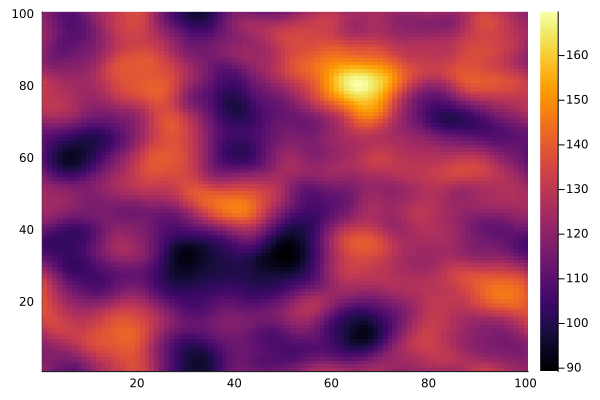

In [176]:
Plots.heatmap(sol_mp[:,:,1,60])

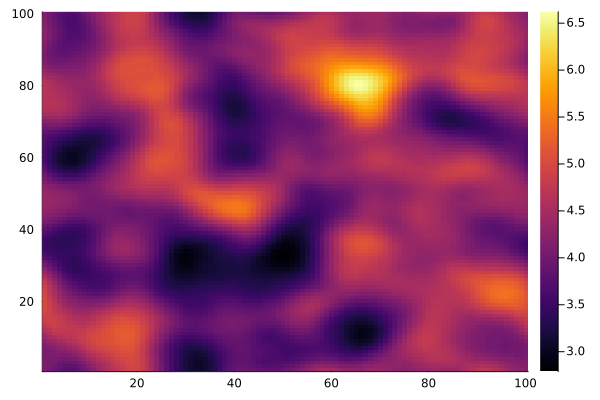

In [178]:
num=60
Plots.heatmap(sol_mp[:,:,5,num]+sol_mp[:,:,6,num]+sol_mp[:,:,4,num])

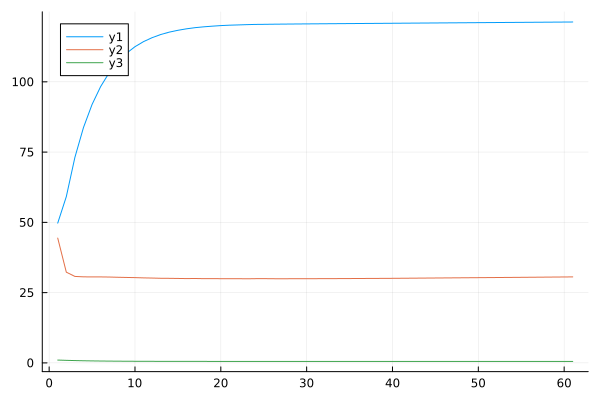

In [168]:
l = length(sol_mp)
tmp1 = mean(sol_mp[:,:,1,1:l], dims=(1,2))
tmp1 = reshape(tmp1, (l))
tmp2 = maximum(sol_mp[:,:,2,1:l], dims=(1,2))
tmp2 = reshape(tmp2, (l))
tmp3 = maximum(sol_mp[:,:,3,1:l], dims=(1,2))
tmp3 = reshape(tmp3, (l))
plot(1:l, [tmp1, tmp2, tmp3])

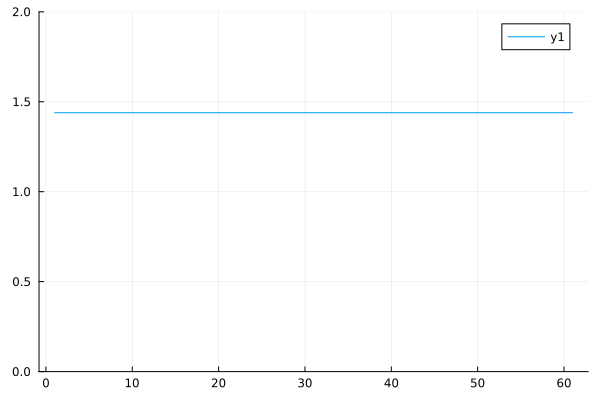

In [182]:
l = length(sol_mp)
tmp3 = mean(sol_mp[:,:,1,1:l]*n, dims=(1,2))
tmp4 = mean(sol_mp[:,:,2,1:l]*n, dims=(1,2))
tmp6 = mean(sol_mp[:,:,6,1:l]*n, dims=(1,2))
tmp5 = mean(sol_mp[:,:,3,1:l], dims=(1,2))
tmp3 = reshape(tmp3+tmp4+tmp5+tmp6, (l))
plot(1:l, [tmp3])
plot!(ylims=(0,2))

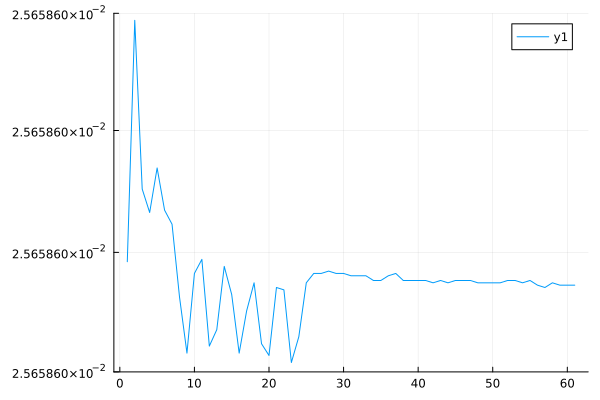

In [181]:
l = length(sol_mp)
tmp3 = mean(sol_mp[:,:,4,1:l], dims=(1,2))
tmp4 = mean(sol_mp[:,:,5,1:l]*n, dims=(1,2))
tmp5 = mean(sol_mp[:,:,6,1:l]*n, dims=(1,2))
tmp2 = reshape(tmp3+tmp4+tmp5, (l))
plot(1:l, [tmp2])


In [177]:
n

60